In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import sqlite3
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('FXH20.scid_BarData.txt', sep=',', skipinitialspace=True) #don't forget to put eleminate the spaces by using skipinitialspace=True 
df

,Date,Time,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume
0,2013/1/4,08:00:00,2116,2116,2114,2114,2873,19,65,35
1,2013/1/4,08:05:00,2114,2115,2113,2114,877,64,683,194
2,2013/1/4,08:10:00,2114,2114,2113,2113,299,37,127,172
3,2013/1/4,08:15:00,2113,2115,2113,2115,229,28,75,154
4,2013/1/4,08:20:00,2115,2115,2113,2113,865,39,677,188
...,...,...,...,...,...,...,...,...,...,...
326342,2020/3/11,21:35:00,2862,2867,2861,2867,395,45,77,318
326343,2020/3/11,21:40:00,2868,2868,2865,2867,221,47,90,131
326344,2020/3/11,21:45:00,2868,2868,2864,2868,427,57,104,323
326345,2020/3/11,21:50:00,2867,2867,2857,2857,1123,111,631,492


In [3]:
## Un test de selection de colonne ...
daily_data = df[df['Date'] == '2013/1/4']
daily_data

,Date,Time,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume
0,2013/1/4,08:00:00,2116,2116,2114,2114,2873,19,65,35
1,2013/1/4,08:05:00,2114,2115,2113,2114,877,64,683,194
2,2013/1/4,08:10:00,2114,2114,2113,2113,299,37,127,172
3,2013/1/4,08:15:00,2113,2115,2113,2115,229,28,75,154
4,2013/1/4,08:20:00,2115,2115,2113,2113,865,39,677,188
...,...,...,...,...,...,...,...,...,...,...
163,2013/1/4,21:35:00,2139,2140,2139,2140,153,32,133,20
164,2013/1/4,21:40:00,2139,2140,2139,2140,291,37,104,187
165,2013/1/4,21:45:00,2139,2140,2136,2137,1220,134,926,294
166,2013/1/4,21:50:00,2137,2138,2136,2138,527,47,289,238


In [4]:
## Converting dates and times to date and time objects on python
df['ConvertDate'] = pd.to_datetime(df['Date'], format="%Y/%m/%d")
df['ConvertTime'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
neuf_heures = dt.datetime.strptime('09:00:00', '%H:%M:%S') 

def isReached(day):
    ''' this function tells us whether the initial absolut high/low is exactly the absolut high/low of the day'''
    
    #Catching data conserning this day:
    daily_data = df[df['ConvertDate'] == day]
    low_abs_daily = daily_data['Low'].min()
    high_abs_daily = daily_data['High'].max()

    #Catching the initial balance of this day:
    entry_data = daily_data[daily_data['ConvertTime'] <= neuf_heures]
    low_abs_initial = entry_data['Low'].min()
    high_abs_initial = entry_data['High'].max()
    
    return (low_abs_daily==low_abs_initial) or (high_abs_daily==high_abs_initial)

In [5]:
# Ici on récupère juste la colonne des Dates: 

df_daily = df[['ConvertDate']]
df_daily

,ConvertDate
0,2013-01-04
1,2013-01-04
2,2013-01-04
3,2013-01-04
4,2013-01-04
...,...
326342,2020-03-11
326343,2020-03-11
326344,2020-03-11
326345,2020-03-11


In [6]:
# Ici on enlève les Dates qui se répètent pour ne que garder chaque date qu'une seule fois et comme ça 
# on peut itérer sur les dates 
## PS: Je n'est pas trouvé d'autre moyen d'itérer sur les dates du tableau de départ à part les éxtraire
##     et en faire un dataframe sans doublons...


df_daily = df_daily.drop_duplicates()
df_daily

,ConvertDate
0,2013-01-04
168,2013-01-07
336,2013-01-08
504,2013-01-09
672,2013-01-10
...,...
325147,2020-03-05
325387,2020-03-06
325627,2020-03-09
325867,2020-03-10


In [7]:
n=0
for index, day in df_daily.iterrows():
    if isReached(day['ConvertDate']):
        n += 1
print(n)        
print((n/1825)*100, '%')

809
44.32876712328767 %


In [8]:
def isReached_with_margin(day, p):
    ''' this function tells us whether the initial absolut high/low is p percent near the absolut high/low of the day'''
    
    #Catching data conserning this day:
    daily_data = df[df['ConvertDate'] == day]
    low_abs_daily = daily_data['Low'].min()
    high_abs_daily = daily_data['High'].max()

    #Catching the initial balance of this day:
    entry_data = daily_data[daily_data['ConvertTime'] <= neuf_heures]
    low_abs_initial = entry_data['Low'].min()
    high_abs_initial = entry_data['High'].max()
    
    def inInterval(y, x, p):
        ''' this function tells us whether y is p percent near x or not'''
        return (y>=x-p) and  (y<=x+p)
    
    
    return (inInterval(low_abs_daily, low_abs_initial, p)) or (inInterval(high_abs_daily, high_abs_initial, p))

In [9]:
n = 0
for index, day in df_daily.iterrows():
    if isReached_with_margin(day['ConvertDate'], 0):
        n += 1
print((n/1825)*100, '%')

44.32876712328767 %


In [10]:
def pourcentage(p):
    ''' calcule le pourcentage des jours où les high journaliés sont à p points les highs initiaux'''
    n = 0
    for index, day in df_daily.iterrows():
        if isReached_with_margin(day['ConvertDate'], p):
            n += 1
    return (n/1825)*100

x=np.linspace(0, 100, 100)
y=np.zeros(len(x))
for i in range(len(x)):
    y[i]=pourcentage(x[i])

<Figure size 720x576 with 0 Axes>

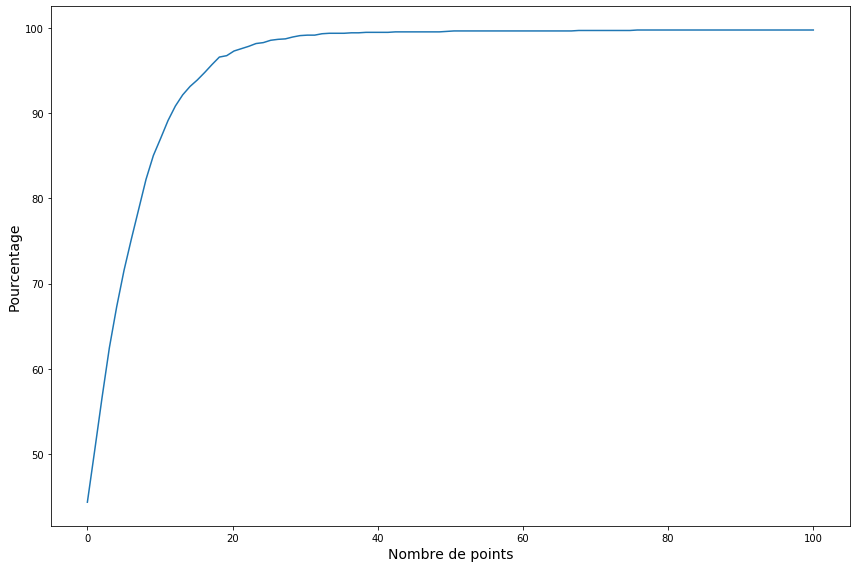

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(x, y)

plt.xlabel('Nombre de points', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)
plt.tight_layout()

,Open,High,Low,Last,Volume,NumberOfTrades,BidVolume,AskVolume
Open,1.000000,0.999990,0.999990,0.999984,-0.081561,-0.128118,-0.078344,-0.080702
High,0.999990,1.000000,0.999984,0.999991,-0.079842,-0.125987,-0.077037,-0.078653
Low,0.999990,0.999984,1.000000,0.999991,-0.083479,-0.130460,-0.080586,-0.082195
Last,0.999984,0.999991,0.999991,1.000000,-0.081650,-0.128198,-0.079099,-0.080114
Volume,-0.081561,-0.079842,-0.083479,-0.081650,1.000000,0.874669,0.975211,0.974734
NumberOfTrades,-0.128118,-0.125987,-0.130460,-0.128198,0.874669,1.000000,0.852180,0.853386
BidVolume,-0.078344,-0.077037,-0.080586,-0.079099,0.975211,0.852180,1.000000,0.901146
AskVolume,-0.080702,-0.078653,-0.082195,-0.080114,0.974734,0.853386,0.901146,1.000000


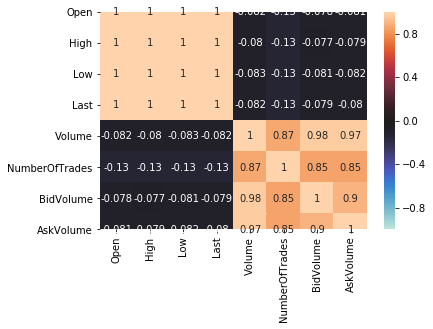

In [11]:
corr = df.corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0)
corr

### <font color=darkred> Softmax regression using 2013 data </font>

In [14]:
print(df['ConvertDate'].iloc[0])

2013-01-04 00:00:00


In [ ]:

data = df[(df['ConvertDate'] >= df['ConvertTime'].iloc[0]) and ]